In [1]:
from dataset_io import *
import numpy as np
import math, random
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(0)

In [2]:
def create_dataset(TrS):
    data_inp = []
    data_out = []
    if len(TrS[0])<3:
        for (contactless, contact) in TrS:
            data_inp.append(contactless)
            data_out.append(contact)
    else:
        for (contactless, contact, peaks) in TrS:
            data_inp.append(contact)
            data_out.append(peaks)
    return np.asarray(data_inp), np.asarray(data_out)

4480
3
730


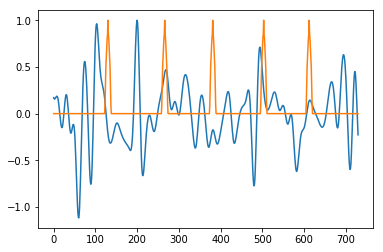

In [3]:
signals = read_contact_dataset(CONTACT_DATASET_NAME)
print(len(signals))
print(len(signals[0]))
print(len(signals[0][0]))
TrS, TsS = GRU_get_training_set(signals, 730)

train_inp, train_out = create_dataset(TrS)

plt.plot(train_inp[0])
plt.plot(train_out[0])

test_inp, test_out = create_dataset(TsS)

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [5]:
input_dim = 1
hidden_size = 30
num_layers = 1

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

r= CustomRNN(input_dim, hidden_size, 1)

In [6]:
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(3):
    hidden = None
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1))) )
    for i in range(len(inp)//2):
        inp1 = inp[i:i+1]
        out1 = out[i:i+1]
        pred = r(inp1)
        optimizer.zero_grad()
        predictions.append(pred.data.numpy())
        loss = loss_func(pred, out1)
        if (3500*t+i)%4000==0:
            print(t, loss.item())
        loss.backward()
        optimizer.step()

0 0.04353734105825424
1 0.04237813502550125
2 0.0059447260573506355


In [7]:
t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 1))), requires_grad=True)
pred_t = r(t_inp)
# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(test_out.reshape((test_inp.shape[0], -1, 1))))).item())

0.041219450533390045


Text(0.5, 1.0, 'Sample num: 109')

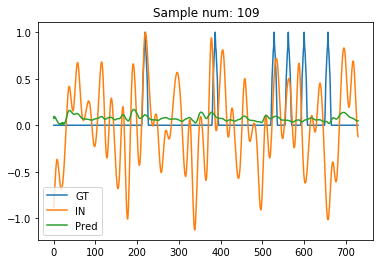

In [8]:
sample_num = 109
plt.plot(test_out[sample_num], label='GT')
plt.plot(test_inp[sample_num], label='IN')
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
plt.legend()
plt.title("Sample num: {}".format(sample_num))